p.294

In [1]:
def minkowskiDist(v1, v2, p):
    """v1とv2は長さの等しい数値配列であるとする
       v1とv2の，p次のミンコフスキー距離を返す"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i]) ** p
    return dist ** (1.0 / p)

p.295

In [2]:
import pylab

In [3]:
class Animal(object):
    def __init__(self, name, features):
        """nameは文字列; featuresは数値のリストとする"""
        self.name = name
        self.features = pylab.array(features)
        
    def getName(self):
        return self.name
    
    def getFeatures(self):
        return self.features
    
    def distance(self, other):
        """otherはAnimalオブジェクトとする
           自分自身とother間のユークリッド距離を返す"""
        return minkowskiDist(self.getFeatures(), other.getFeatures(), 2)

In [4]:
def compareAnimals(animals, precision):
    """animalsはAnimalオブジェクトのリスト、precisionは非負の整数とする
       それぞれのAnimal間のユークリッド距離の表を作る"""
    pylab.figure(dpi=125)

    #行と列のラベルを作る
    columnLabels = []
    for a in animals:
        columnLabels.append(a.getName())
    rowLabels = columnLabels[:]
    
    tableVals = []
    
    #Animal間の距離を得る
    #行について
    for a1 in animals:
        row = []
        #列について
        for a2 in animals:
            if a1 == a2:
                row.append('--')
            else:
                distance = a1.distance(a2)
                row.append(str(round(distance, precision)))
        tableVals.append(row)
    #表を作る
    table = pylab.table(rowLabels = rowLabels,
                        colLabels = columnLabels,
                        cellText = tableVals,
                        cellLoc = 'center',
                        loc = 'center',
                        colWidths = [0.2]*len(animals))
    
    table.scale(1, 2.5)
    pylab.axis('off') # x軸とy軸を表示しない
    pylab.savefig('distances')
    pylab.show()

p.296

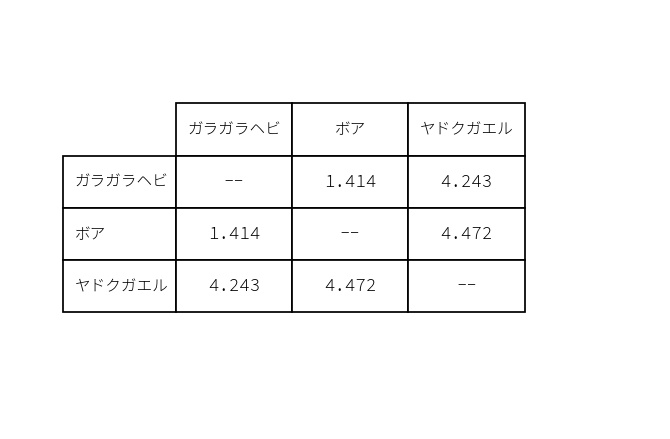

In [5]:
rattlesnake = Animal(u'ガラガラヘビ', [1, 1, 1, 1, 0])
boa         = Animal(u'ボア',         [0, 1, 0, 1, 0])
dartFrog    = Animal(u'ヤドクガエル', [1, 0, 1, 0, 4])
animals = [rattlesnake, boa, dartFrog]
compareAnimals(animals, 3)

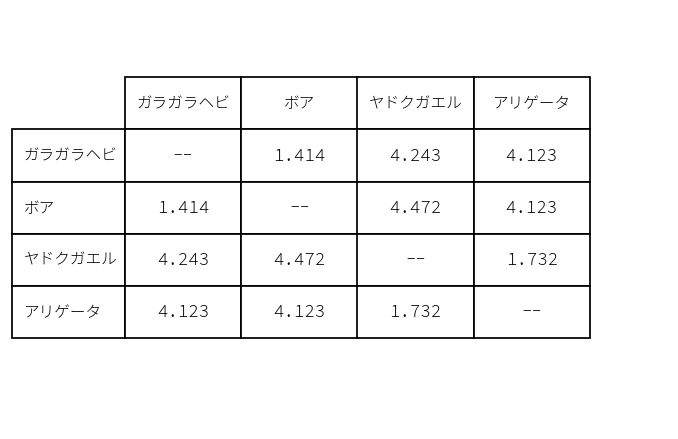

In [6]:
alligator = Animal(u'アリゲータ', [1, 1, 0, 1, 4])
animals.append(alligator)
compareAnimals(animals, 3)

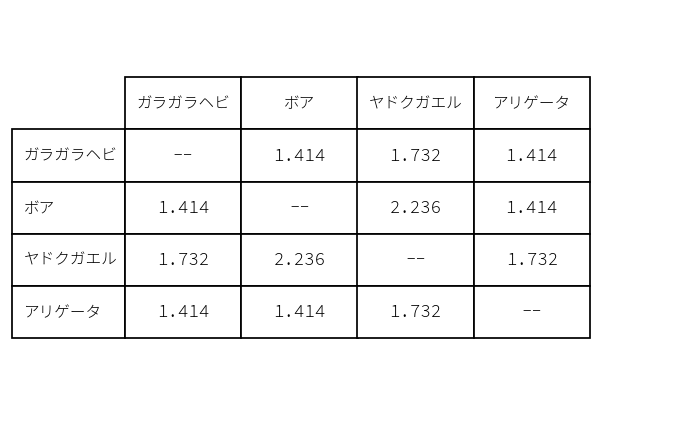

In [7]:
# 足の本数の特徴量ベクトルの値を、足の本数が0本のとき0、4本のとき1にする
rattlesnake = Animal(u'ガラガラヘビ', [1, 1, 1, 1, 0])
boa         = Animal(u'ボア',         [0, 1, 0, 1, 0])
dartFrog    = Animal(u'ヤドクガエル', [1, 0, 1, 0, 1])
alligator   = Animal(u'アリゲータ',   [1, 1, 0, 1, 1])
animals = [rattlesnake, boa, dartFrog, alligator]
compareAnimals(animals, 3)

p.299

In [8]:
class Example(object):
    
    def __init__(self, name, features, label = None):
        #featuresは数の配列である
        self.name = name
        self.features = features
        self.label = label
        
    def dimensionality(self):
        return len(self.features)
    
    def getFeatures(self):
        return self.features[:]
    
    def getLabel(self):
        return self.label
    
    def getName(self):
        return self.name
    
    def distance(self, other):
        return minkowskiDist(self.features, other.getFeatures(), 2)
    
    def __str__(self):
        return self.name + ':' + str(self.features) + ':' + str(self.label)

p.300

In [9]:
class Cluster(object):
    
    def __init__(self, examples, exampleType):
        """examplesはexampleType型のリストとする"""
        self.examples = examples
        self.exampleType = exampleType
        self.centroid = self.computeCentroid()
        
    def update(self, examples):
        """クラスターのexamplesを新しい標本examplesで置き換える
           クラスターの重心がどのくらい移動したかを返す"""
        oldCentroid = self.centroid
        self.examples = examples
        if len(examples) > 0:
            self.centroid = self.computeCentroid()
            return oldCentroid.distance(self.centroid)
        else:
            return 0.0
        
    def members(self):
        for e in self.examples:
            yield e
        
    def size(self):
        return len(self.examples)
    
    def getCentroid(self):
        return self.centroid
    
    def computeCentroid(self):
        dim = self.examples[0].dimensionality()
        totVals = pylab.array([0.0] * dim)
        for e in self.examples:
            totVals += e.getFeatures()
        centroid = self.exampleType(u'重心', totVals / float(len(self.examples)))
        return centroid
    
    def variance(self):
        totDist = 0.0
        for e in self.examples:
            totDist += (e.distance(self.centroid)) ** 2
        return totDist ** 0.5
    
    def __str__(self):
        names = []
        for e in self.examples:
            names.append(e.getName())
        names.sort()
        result = 'クラスター: 重心は' + str(self.centroid.getFeatures()) + '、要素:\n  '
        for e in names:
            result = result + e + ', '
        return result[:-2]

p.302

In [10]:
def kmeans(examples, exampleType, k, verbose):
    """examplesはexmapleType型の標本リストであり、
       kは正の整数，verboseはブール型とする。
       k個のクラスターからなるリストを返す。
       もしverboseの値がTrueならば、k-平均法の各繰り返しの途中結果を出力する"""
    # k個の初期中心をランダムに選ぶ
    initialCentroids = random.sample(examples, k)
    
    # それぞれの中心ただ一つからなるクラスターを作成する
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e], exampleType))
        
    # 重心が変化しなくなるまで繰り返す
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1
        # k個の空のリストからなるリストを作成する
        newClusters = []
        for i in range(k):
            newClusters.append([])

        # それぞれのサンプルを最も近い重心へと関連づける
        for e in examples:
            # eに最も近い重心を見つける
            smallestDistance = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            # eを適切なクラスターの標本リストへ加える
            newClusters[index].append(e)
            
        # それぞれのクラスターを更新する、重心が変化したかどうかをチェック
        converged = True
        for i in range(len(clusters)):
            if clusters[i].update(newClusters[i]) > 0.0:
                converged = False
        if verbose:
            print 'くりかえし #' + str(numIterations)
            for c in clusters:
                print c
            print '' # 空行を追加する
    return clusters

p.303

In [11]:
def dissimilarity(clusters):
    totDist = 0.0
    for c in clusters:
        totDist += c.variance()
    return totDist

In [12]:
import random

In [13]:
def trykmeans(examples, exampleType, numClusters, numTrials,
              verbose = False):
    """kmeans関数をnumTrials回呼び出し、
       最も類似性が小さいクラスタリングを返す"""
    best = kmeans(examples, exampleType, numClusters, verbose)
    minDissimilarity = dissimilarity(best)
    for trial in range(1, numTrials):
        clusters = kmeans(examples, exampleType, numClusters, verbose)
        currDissimilarity = dissimilarity(clusters)
        if currDissimilarity < minDissimilarity:
            best = clusters
            minDissimilarity = currDissimilarity
    return best

p.304

In [14]:
def genDistribution(xMean, xSD, yMean, ySD, n, namePrefix):
    samples = []
    for s in range(n):
        x = random.gauss(xMean, xSD)
        y = random.gauss(yMean, ySD)
        samples.append(Example(namePrefix + str(s), [x, y]))
    return samples

In [15]:
def plotSamples(samples, marker):
    xVals, yVals = [], []
    for s in samples:
        x = s.getFeatures()[0]
        y = s.getFeatures()[1]
        pylab.annotate(s.getName(), xy = (x, y),
                       xytext = (x + 0.13, y - 0.07),
                       fontsize = 'x-large')
        xVals.append(x)
        yVals.append(y)
    pylab.plot(xVals, yVals, marker)

In [16]:
def contrivedTest(numTrials, k, verbose):
    pylab.figure(dpi=125)
    random.seed(0)
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean, xSD, yMean, ySD, n, '1.')
    plotSamples(d1Samples, 'b^')
    d2Samples = genDistribution(xMean + 3, xSD, yMean + 1, ySD, n, '2.')
    plotSamples(d2Samples, 'ro')
    clusters = trykmeans(d1Samples + d2Samples, Example, k, numTrials, verbose)
    print '最終結果'

    centroids = []
    for c in clusters:
        print '', c
    pylab.show()

くりかえし #1
クラスター: 重心は[4.57800047 5.35921276]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
クラスター: 重心は[3.79646584 2.99635148]、要素:
  1.9

くりかえし #2
クラスター: 重心は[4.80105783 5.73986393]、要素:
  1.1, 1.2, 1.4, 1.5, 1.6, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
クラスター: 重心は[3.75252146 3.74468698]、要素:
  1.0, 1.3, 1.7, 1.8, 1.9

くりかえし #3
クラスター: 重心は[5.6388835  6.02296994]、要素:
  1.6, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
クラスター: 重心は[3.19452848 4.28541384]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.8, 1.9

くりかえし #4
クラスター: 重心は[5.93613865 5.96069975]、要素:
  2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
クラスター: 重心は[3.14170883 4.52143963]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9

くりかえし #5
クラスター: 重心は[5.93613865 5.96069975]、要素:
  2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
クラスター: 重心は[3.14170883 4.52143963]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9

最終結果
 クラスター: 重心は[5.93613865 5.96069975]、要素:
  2.0, 2.1, 2.2,

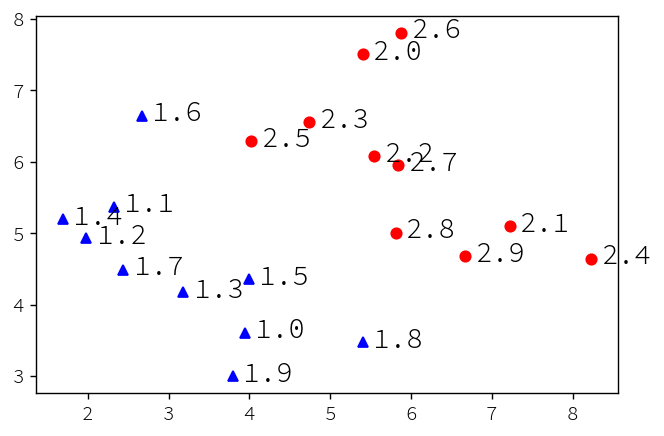

In [17]:
contrivedTest(1, 2, True)

最終結果
 クラスター: 重心は[5.88777325 5.73417409]、要素:
  1.8, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
 クラスター: 重心は[2.89032989 4.63838655]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.9


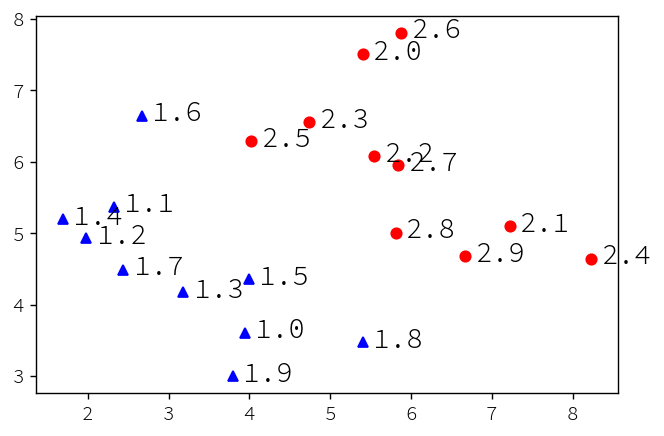

In [18]:
contrivedTest(40, 2, False)

p.306

In [19]:
# 指練習
def contrivedTest(numTrials, k, verbose):
    pylab.figure(dpi=125)
    random.seed(0)
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean, xSD, yMean, ySD, n, '1.')
    plotSamples(d1Samples, 'b^')
    d2Samples = genDistribution(xMean + 3, xSD, yMean + 1, ySD, n, '2.')
    plotSamples(d2Samples, 'ro')
    clusters = trykmeans(d1Samples + d2Samples, Example, k, numTrials, verbose)
    print '最終結果'

    centroids = []
    for c in clusters:
        print '', c
        centroids.append(c.getCentroid())
    x0 = centroids[0].getFeatures()[0]
    y0 = centroids[0].getFeatures()[1]
    x1 = centroids[1].getFeatures()[0]
    y1 = centroids[1].getFeatures()[1]
    pylab.plot([x0, x1], [y0, y1], 'go')

    a = (y1 - y0) / (x1 - x0)
    a = -1 / a
    xs = [0, 0]
    ys = [10, 0]
    xs[0] = (ys[0] - (y0 + y1) / 2.0) / a + (x0 + x1) / 2.0
    xs[1] = (ys[1] - (y0 + y1) / 2.0) / a + (x0 + x1) / 2.0
    pylab.plot(xs, ys, 'g-')

    pylab.xlim(0, 13)
    pylab.show()

最終結果
 クラスター: 重心は[5.93613865 5.96069975]、要素:
  2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
 クラスター: 重心は[3.14170883 4.52143963]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9


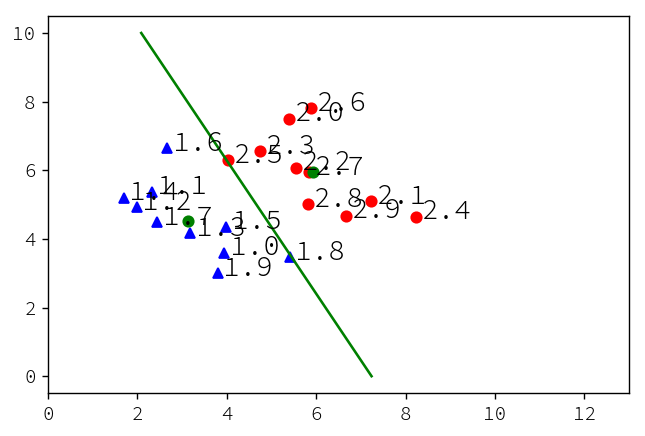

In [20]:
contrivedTest(1, 2, False)

最終結果
 クラスター: 重心は[5.88777325 5.73417409]、要素:
  1.8, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
 クラスター: 重心は[2.89032989 4.63838655]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.9


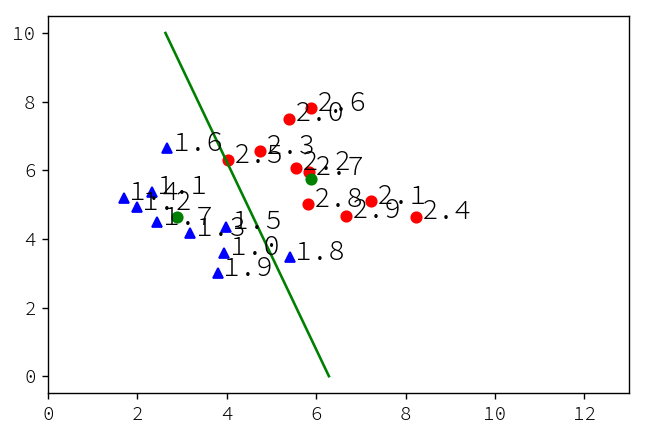

In [21]:
contrivedTest(40, 2, False)

In [22]:
def contrivedTest2(numTrials, k, verbose):
    pylab.figure(dpi=125)
    random.seed(0)
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 8
    d1Samples = genDistribution(xMean,xSD, yMean, ySD, n, '1.')
    plotSamples(d1Samples, 'b^')
    d2Samples = genDistribution(xMean+3,xSD,yMean, ySD, n, '2.')
    plotSamples(d2Samples, 'ro')
    d3Samples = genDistribution(xMean, xSD, yMean+3, ySD, n, '3.')
    plotSamples(d3Samples, 'gd')
    clusters = trykmeans(d1Samples + d2Samples + d3Samples, Example, k, numTrials, verbose)
    print '最終結果'
    for c in clusters:
        print '', c
    pylab.show()

最終結果
 クラスター: 重心は[7.66239972 3.55222681]、要素:
  2.0, 2.1, 2.3, 2.6
 クラスター: 重心は[3.36736761 6.35376823]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 2.2, 2.4, 2.5, 2.7, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7


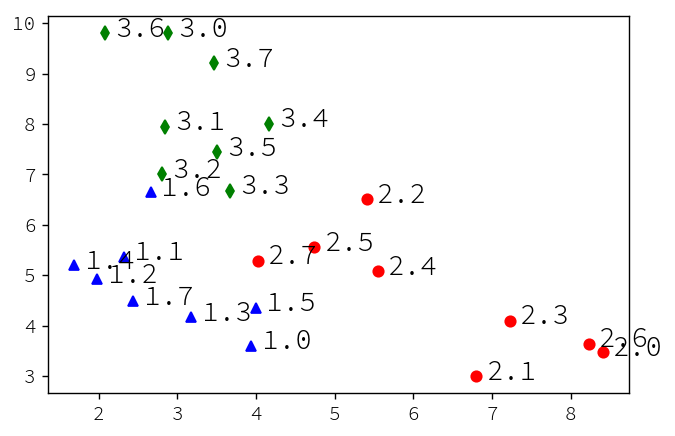

In [23]:
contrivedTest2(40,  2, False)

最終結果
 クラスター: 重心は[7.66239972 3.55222681]、要素:
  2.0, 2.1, 2.3, 2.6
 クラスター: 重心は[3.10687385 8.46084886]、要素:
  3.0, 3.1, 3.2, 3.4, 3.5, 3.6, 3.7
 クラスター: 重心は[3.50763348 5.21918636]、要素:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 2.2, 2.4, 2.5, 2.7, 3.3


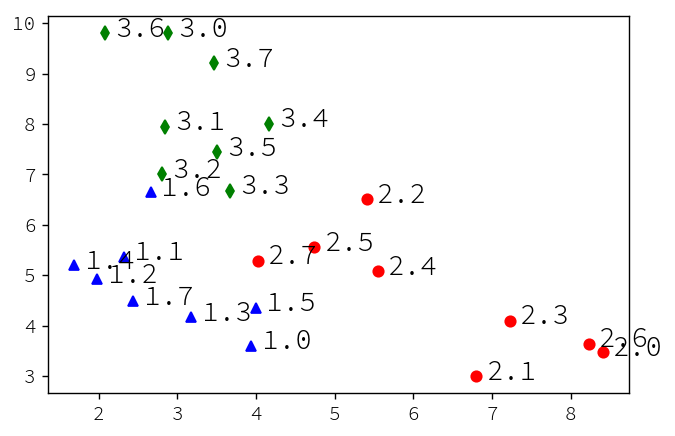

In [24]:
contrivedTest2(40,  3, False)

最終結果
 クラスター: 重心は[7.66239972 3.55222681]、要素:
  2.0, 2.1, 2.3, 2.6
 クラスター: 重心は[2.80974427 9.60386549]、要素:
  3.0, 3.6, 3.7
 クラスター: 重心は[3.70472053 4.04178035]、要素:
  1.0, 1.3, 1.5
 クラスター: 重心は[2.10900238 4.99452866]、要素:
  1.1, 1.2, 1.4, 1.7
 クラスター: 重心は[4.92742554 5.60609442]、要素:
  2.2, 2.4, 2.5, 2.7
 クラスター: 重心は[3.27637435 7.28932247]、要素:
  1.6, 3.1, 3.2, 3.3, 3.4, 3.5


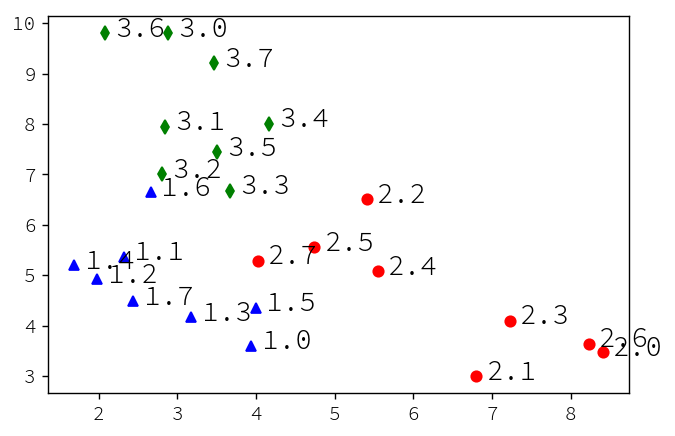

In [25]:
contrivedTest2(40,  6, False)

p.309

In [26]:
import string

In [27]:
def readMammalData(fName):
    dataFile = open(fName, 'r')
    numFeatures = 0
    #ファイルの先頭の処理
    for line in dataFile: #　特徴の数を調べる
        if line[0:6] == '#Label': #　特徴の終了を示す
            break
        if line[0:5] != '#Name':
            numFeatures += 1
    featureVals = []
    
    # featureVals、speciesNames、labelListの生成
    featureVals, speciesNames, labelList = [], [], []
    for i in range(numFeatures):
        featureVals.append([])
        
    # コメント後の行ごとの処理
    for line in dataFile:
        dataLine = string.split(line[:-1], ',') #改行の除去、その後分割
        speciesNames.append(dataLine[0])
        classLabel = float(dataLine[-1])
        labelList.append(classLabel)
        for i in range(numFeatures):
            featureVals[i].append(float(dataLine[i+1]))
            
    # 特徴ベクトルを含むリストを作るためにfeatureValsを使う
    # それぞれの哺乳類について
    featureVectorList = []
    for mammal in range(len(speciesNames)):
        featureVector = []
        for feature in range(numFeatures):
            featureVector.append(featureVals[feature][mammal])
        featureVectorList.append(featureVector)
    return featureVectorList, labelList, speciesNames

p.310

In [28]:
def buildMammalExamples(featureList, labelList, speciesNames):
    examples = []
    for i in range(len(speciesNames)):
        features = pylab.array(featureList[i])
        example = Example(speciesNames[i], features, labelList[i])
        examples.append(example)
    return examples

In [29]:
def testTeeth(numClusters, numTrials):
    features, labels, species = readMammalData('dentalFormulas.txt')
    examples = buildMammalExamples(features, labels, species)
    bestClustering = trykmeans(examples, Example, numClusters, numTrials)
    for c in bestClustering:
        names = ''
        for p in c.members():
            names += p.getName() + ', '
        print '\n', names[:-2] # 後端のコンマとスペースを削除
        herbivores, carnivores, omnivores = 0, 0, 0
        for p in c.members():
            if p.getLabel() == 0:
                herbivores += 1
            elif p.getLabel() == 1:
                carnivores += 1
            else:
                omnivores += 1
        print '草食動物', herbivores, '、肉食動物', carnivores, '、雑食動物', omnivores

In [30]:
random.seed(0)
testTeeth(3, 20)


ウシ, エルク, ムース, アシカ
草食動物 3 、肉食動物 1 、雑食動物 0

アナグマ, クーガー, イヌ, キツネ, モルモット, ジャガー, カンガルー, ミンク, モグラ, マウス, ヤマアラシ, ブタ, ウサギ, アライグマ, ラット, コウモリ, スカンク, リス, ウッドチャック, オオカミ
草食動物 4 、肉食動物 9 、雑食動物 7

クマ, シカ, オットセイ, ハイイロアザラシ, ヒト, ライオン
草食動物 1 、肉食動物 3 、雑食動物 2


p.311

In [31]:
def scaleFeatures(vals):
    """valsは数列とする"""
    result = pylab.array(vals)
    mean = sum(result) / float(len(result))
    result = result - mean
    sd = stdDev(result)
    result = result / sd
    return result

In [32]:
def variance(X):
    """Xを数のリストとする
       Xの分散を返す"""
    mean = sum(X) / len(X)
    tot = 0.0
    for x in X:
        tot += (x - mean) ** 2
    return tot / len(X)

In [33]:
def stdDev(X):
    """Xを数のリストとする
       Xの標準偏差を返す"""
    return variance(X) ** 0.5

In [34]:
v1, v2 = [], []
for i in range(1000):
    v1.append(random.gauss(100, 5))
    v2.append(random.gauss(50, 10))
v1 = scaleFeatures(v1)
v2 = scaleFeatures(v2)
print 'v1の平均 =', round(sum(v1) / len(v1), 4), '、v1の標準偏差 =', round(stdDev(v1), 4)
print 'v2の平均 =', round(sum(v2) / len(v2), 4), '、v2の標準偏差 =', round(stdDev(v2), 4)

v1の平均 = -0.0 、v1の標準偏差 = 1.0
v2の平均 = -0.0 、v2の標準偏差 = 1.0


p.312

In [35]:
def readMammalData(fName, scale):
    """scaleはブール型とする。
       もしTrueならば特徴ベクトルをスケーリングする"""
    dataFile = open(fName, 'r')
    numFeatures = 0
    # ファイルの先頭の処理
    for line in dataFile: # 特徴の数を調べる
        if line[0:6] == '#Label': # 特徴の終了を示す
            break
        if line[0:5] != '#Name':
            numFeatures += 1
    featureVals = []
    
    # featureVals、speciesNames、labelListの生成
    featureVals, speciesNames, labelList = [], [], []
    for i in range(numFeatures):
        featureVals.append([])
        
    # コメント後の行ごとの処理
    for line in dataFile:
        dataLine = string.split(line[:-1], ',') # 改行の除去; その後分割
        speciesNames.append(dataLine[0])
        classLabel = float(dataLine[-1])
        labelList.append(classLabel)
        for i in range(numFeatures):
            featureVals[i].append(float(dataLine[i+1]))

    # 特徴ベクトルを含むリストを作るためにfeatureValsを使う
    # それぞれのほ乳類について必要なら特徴ベクトルをスケーリング
    if scale:
        for i in range(numFeatures):
            featureVals[i] = scaleFeatures(featureVals[i])
    featureVectorList = []
    for mammal in range(len(speciesNames)):
        featureVector = []
        for feature in range(numFeatures):
            featureVector.append(featureVals[feature][mammal])
        featureVectorList.append(featureVector)
    return featureVectorList, labelList, speciesNames

In [36]:
def testTeeth(numClusters, numTrials, scale):
    features, classes, species = readMammalData('dentalFormulas.txt', scale)
    examples = buildMammalExamples(features, classes, species)
    #この後のコードは前のバージョンの部分と同じ
    bestClustering = trykmeans(examples, Example, numClusters, numTrials)
    for c in bestClustering:
        names = ''
        for p in c.members():
            names += p.getName() + ', '
        print '\n', names[:-2]
        herbivores, carnivores, omnivores = 0, 0, 0
        for p in c.members():
            if p.getLabel() == 0:
                herbivores += 1
            elif p.getLabel() == 1:
                carnivores += 1
            else:
                omnivores += 1
        print '草食動物', herbivores, '、肉食動物', carnivores, '、雑食動物', omnivores

In [37]:
print 'スケーリングなしのクラスター'
random.seed(0)
testTeeth(3, 20, False)
print '\nスケーリングしたクラスター'
random.seed(0)
testTeeth(3, 20, True)

スケーリングなしのクラスター

ウシ, エルク, ムース, アシカ
草食動物 3 、肉食動物 1 、雑食動物 0

アナグマ, クーガー, イヌ, キツネ, モルモット, ジャガー, カンガルー, ミンク, モグラ, マウス, ヤマアラシ, ブタ, ウサギ, アライグマ, ラット, コウモリ, スカンク, リス, ウッドチャック, オオカミ
草食動物 4 、肉食動物 9 、雑食動物 7

クマ, シカ, オットセイ, ハイイロアザラシ, ヒト, ライオン
草食動物 1 、肉食動物 3 、雑食動物 2

スケーリングしたクラスター

アナグマ, クマ, クーガー, ウシ, シカ, イヌ, キツネ, オットセイ, ハイイロアザラシ, エルク, ヒト, ジャガー, ライオン, ミンク, モグラ, ムース, ブタ, アライグマ, コウモリ, アシカ, スカンク, オオカミ
草食動物 4 、肉食動物 13 、雑食動物 5

カンガルー, ウサギ, リス, ウッドチャック
草食動物 2 、肉食動物 0 、雑食動物 2

モルモット, マウス, ヤマアラシ, ラット
草食動物 2 、肉食動物 0 、雑食動物 2
